In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/juangomez/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [44]:
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import os

def load_idx(filepath):
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# load train images
x_train = load_idx(os.path.join(path, "train-images.idx3-ubyte"))[16:].reshape(-1, 28, 28)
y_train = load_idx(os.path.join(path, "train-labels.idx1-ubyte"))[8:]

# load test images
x_test = load_idx(os.path.join(path, "t10k-images.idx3-ubyte"))[16:].reshape(-1, 28, 28)
y_test = load_idx(os.path.join(path, "t10k-labels.idx1-ubyte"))[8:]

# Get val images
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (50000, 28, 28)
Train labels shape: (50000,)
Validation images shape: (10000, 28, 28)
Validation labels shape: (10000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


La imagen mostrada corresponse a un: 5


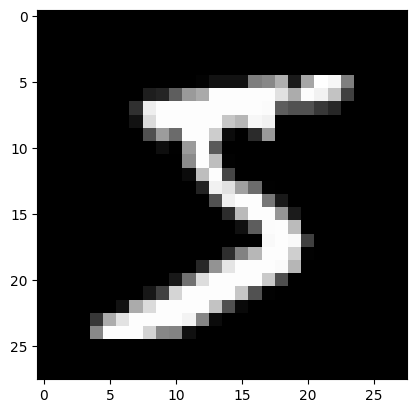

In [46]:
def plt_image(image):
    plt.imshow(image, cmap=plt.get_cmap('gray'))

image1 = x_train[0]
label1 = y_train[0]
print(f'La imagen mostrada corresponse a un: {label1}')
plt_image(image1)

In [47]:
x_train = x_train.reshape(50000, -1)
x_val = x_val.reshape(10000, -1)
x_test = x_test.reshape(10000, -1)

y_train = y_train.reshape(50000, -1)
y_val = y_val.reshape(10000, -1)
y_test = y_test.reshape(10000, -1)

In [48]:
print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (50000, 784)
Train labels shape: (50000, 1)
Validation images shape: (10000, 784)
Validation labels shape: (10000, 1)
Test images shape: (10000, 784)
Test labels shape: (10000, 1)


# Preprocessing

In [49]:
def normalizeImage(x_data):
    x_mean = np.mean(x_data)
    x_std = np.std(x_data)
    return (x_data - x_mean) / x_std


x_train_normalize = normalizeImage(x_train)
x_val_normalize = normalizeImage(x_val)
x_test_normalize = normalizeImage(x_test)

# Create Batch Generator

In [50]:
def create_minibatches(x, y, batch_size, shuffle= True):
    """
        This is a generator function that generates mini-batches of data.
    """
    assert x.shape[0] == y.shape[0]
    len_data = x.shape[0]
    if shuffle:
        idx = np.random.permutation(len_data)
        x = x[idx]
        y = y[idx]
    return ((x[i:i+batch_size], y[i:i+batch_size]) for i in range(0, len_data, batch_size))

## Init parameters

In [ ]:
def init_parameters(input_size, neurons):
    """
        This function initializes the weights and biases of the neural network.
        - neurons: list containing the number of neurons in each layer.
        - input_size: the size of the image.
    """
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))

    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))

    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


parameters = init_parameters(28*28, [200, 10])
parameters2 = init_parameters()

print("W1 shape:", parameters['W1'].shape)
print("b1 shape:", parameters['b1'].shape)
print("W2 shape:", parameters['W2'].shape)
print("b2 shape:", parameters['b2'].shape)

W1 shape: (200, 784)
b1 shape: (200, 1)
W2 shape: (10, 200)
b2 shape: (10, 1)


## Activation Function

In [52]:
def relu(x):
    return np.maximum(0, x)

## Linear Pass

In [60]:
def scores(x, parameters, activation_fcn):
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1)
    z2 = parameters['W2'] @ a1 + parameters['b2']
    return z2, z1, a1

In [54]:
print(x_train[:64].shape)

(64, 784)


In [61]:
scores, z1, a1 = scores(x_train[:64].T, parameters, relu)

In [62]:
scores.shape

(10, 64)

## Softmax

In [76]:
def softmax(x):
    exp_x = np.exp(x)
    sum_exp_scores = np.sum(exp_x, axis=0)
    return exp_x / sum_exp_scores

## Loss Function

In [77]:
def cross_entropy(scores, y, batch_size):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat))/batch_size
    return probs, cost

In [87]:
scores_shape = cross_entropy(scores, y_train[:64], 64)[0].shape
print(scores_shape)

(10, 64)


In [81]:
y_train.squeeze().shape

(50000,)

## backward

In [88]:
def backward(probs, x, y, z1, a1, parameters, batch_size):
    grads = {}
    # Subtract 1 to the correct class in each columns(batch_size)
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    dz2 = probs.copy()

    dw2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis=1, keedpdims=True)/batch_size
    da1 = parameters['W2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0] = 0

    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True)/batch_size

    assert parameters['W1'].shape == dW1.shape
    assert parameters['b1'].shape == db1.shape
    assert parameters['W2'].shape == dw2.shape
    assert parameters['b2'].shape == db2.shape

    grads = {'w1': dW1, 'b1': db1, 'w2': dw2, 'b2': db2}

    return grads
     




In [90]:
y_hat, cost = cross_entropy(scores, y_train[:64], 64)
grads = backward(y_hat, x_train[:64].T, y_train[:64], z1, a1, parameters, 64)

TypeError: sum() got an unexpected keyword argument 'keedpdims'

In [ ]:
def ejemplo_generador():
    return (x for x in range(5)) 

In [58]:
scores

array([[ 2.20728979e-02,  2.55196681e-02,  8.17870211e-03,
        -8.11345865e-03,  2.27898031e-02,  1.83221742e-02,
         1.75256442e-02, -9.26830460e-03,  9.55067093e-03,
         3.16028023e-02, -1.05713689e-02,  6.81202480e-03,
        -2.81855401e-02,  1.72103468e-02,  1.21268048e-02,
         6.03377083e-02,  9.58488964e-03,  2.99290697e-02,
         1.50154235e-04,  4.02216450e-02,  4.59196887e-04,
         1.04392977e-02,  2.07955401e-02, -7.52002629e-03,
         7.11403508e-03, -2.13899693e-02, -1.41151534e-02,
        -2.34514222e-02,  1.40319703e-02,  1.10741839e-02,
        -3.68715621e-03,  2.14255281e-02,  2.21879702e-02,
         3.42226726e-02,  8.13039963e-03,  1.54173037e-02,
         1.62878260e-02,  2.48731959e-02,  2.44721524e-02,
         2.65208284e-02, -6.66000341e-04,  2.11459679e-02,
        -7.19981228e-04,  1.35135977e-02, -3.46152945e-03,
         2.86079230e-03, -1.24771768e-03,  4.41184232e-02,
        -2.66975236e-03, -3.94137037e-03, -3.65215524e-0

In [ ]:
gen = ejemplo_generador()
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))


0
1
2
3
4
